# Chlorophyll 
### Comparing vertical chlorophyll profiles with BATS and HOTS station. BATS, for example, has a DCM that ranges between 70-120m (Steinberg et al. 2001 DSR II); compare with HOT, which typically has a DCM of ~100-150m deep at HOT (except for the summer bloom, Letelier et al. 2004 L&O). Moeller et al. 2019 recently suggested that you need some kind of representation of mixotrophy in order to get a deep enough DCM -- so I wouldn't worry too much if our DCMs are too shallow. 

In [10]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [11]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [12]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

# input file

In [13]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [14]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [15]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr*', recursive=True))

In [16]:
new= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [17]:
new.diat1Chl

<xarray.DataArray 'diat1Chl' (time: 12, z_t_150m: 15, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 15, 384, 320), dtype=float32, chunksize=(1, 15, 384, 320)>
Coordinates:
    ULONG     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * time      (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Diatoms 1 Chlorophyll
    units:         mg/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [18]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/SP*/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [19]:
diat1_ds.diat1Chl

<xarray.DataArray 'diat1Chl' (time: 12, z_t_150m: 15, lat: 180, lon: 360)>
dask.array<concatenate, shape=(12, 15, 180, 360), dtype=float32, chunksize=(1, 15, 180, 360)>
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * time      (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Attributes:
    long_name:     Diatoms 1 Chlorophyll
    units:         mg/m^3
    grid_loc:      3114
    cell_methods:  time: mean

Text(0.5, 1.0, '$mg/m^3$')

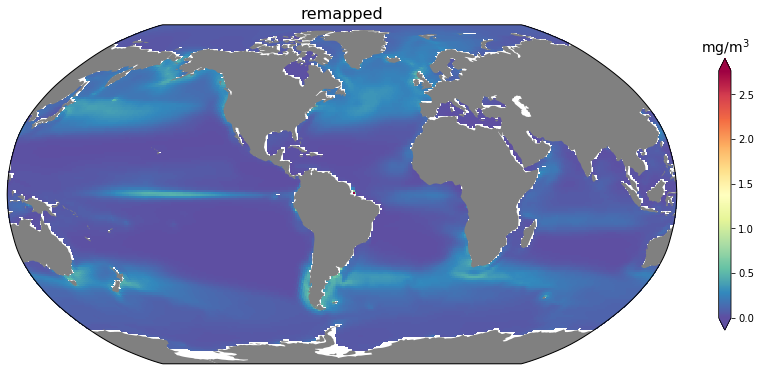

In [20]:
fig = plt.figure(figsize=(15, 10))
lat = diat1_ds.lat
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.nanmean(diat1_ds.diat1Chl[:,0,:,:],axis=0), coord=diat1_ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('remapped', fontsize =16)
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both')
cbar.ax.set_title('$mg/m^3$', fontsize = 14)

In [21]:
chla_new = np.nansum(np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan

## The BATS site is situated in the western North Atlantic subtropical gyre or Sargasso Sea. 

The BATS station lies 82 km southeast of the island of Bermuda (31°40′ N, 64°10′ W) , approximately 8 km south of the Ocean Flux program (OFP) long-term deep sediment trap mooring (Conte et al., 2001) (Fig. 2). Bottom depth at the BATS deployment area is ∼4680 m. The BATS core cruises consist of a single 4–5 d cruise at monthly intervals. Between January and April an extra “bloom cruise” is added to increase sampling frequency to bimonthly during the spring-bloom period. Additional “validation cruises” (2–4 yr−1) resolve spatial variability of biogeochemical parameters near BATS.

In [22]:
# (31°40′ N, 64°10′ W)
# Longitude is in degrees East, so to get degrees west, I would need something like this...  
# 180 + 64.10 = 244.10
res_lon = np.where((new.TLONG[1,:].values >244) & (new.TLONG[1,:].values <245 ))
new.TLONG[1,252].values

# Latitude degrees_north
res_lat = np.where((new.TLAT[:,1].values >31) & (new.TLAT[:,1].values <32 ))
new.TLAT[282,1].values

array(31.28255745)

### with regridded grid 

In [23]:
# (31°40′ N, 64°10′ W)
# longitude in degrees East
res_lon = np.where(pp_ds.lon == -64)

# Latitude degrees_north
res_lat = np.where(pp_ds.lat == 31.5)

### HOT station at station ALOHA (22° 45'N, 158° 00'W)

In [24]:
#(22° 45'N, 158° 00'W)
# longitude in degrees East
res_lon = np.where(pp_ds.lon == -158)

# Latitude degrees_north
res_lat = np.where(pp_ds.lat == 22.5)

In [25]:
res_lon

(array([22]),)

In [26]:
res_lat

(array([112]),)

## Check if this point does correspond to the BATS site

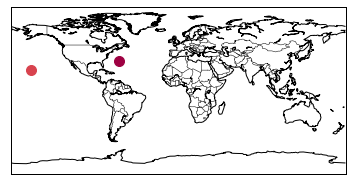

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
map = Basemap()
cmap=matplotlib.cm.get_cmap('Spectral', 10)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'white')
map.drawmapboundary()
lon = pp_ds.lon[116]
lat = pp_ds.lat[121]
x,y = map(lon, lat)
map.plot(x, y, 'o', markersize=10,color=cmap(0))
lon1 = pp_ds.lon[22]
lat1 = pp_ds.lat[112]
x1,y1 = map(lon1, lat1)
map.plot(x1, y1, 'o', markersize=10,color=cmap(1))
#map.plot(pp_ds.ppChl[0,0,100, 300], 'bo', markersize=24) 
plt.show()

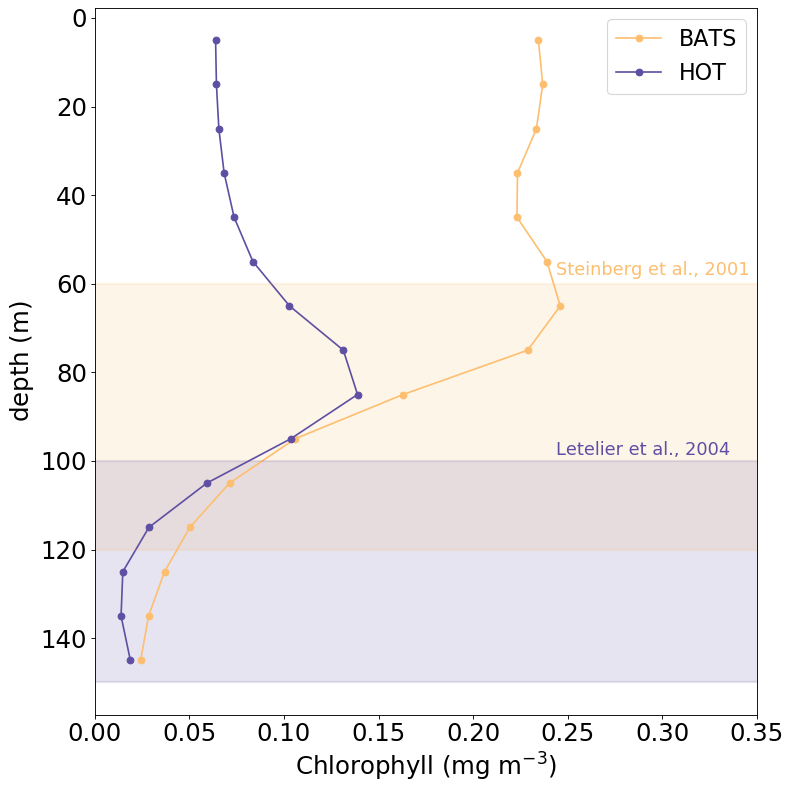

In [28]:
import matplotlib.transforms as mtransforms

import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')


ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.invert_yaxis()

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
bats_low = 60
bats_high = 120
hot_low=100
hot_high = 150
ax.axhline(bats_low, color=cmap(3), lw=2, alpha=0.15)
ax.axhline(bats_high, color=cmap(3), lw=2, alpha=0.15)

ax.axhline(hot_low, color=cmap(9), lw=2, alpha=0.15)
ax.axhline(hot_high, color=cmap(9), lw=2, alpha=0.15)

ax.fill_between([0,0.35], bats_low, bats_high,facecolor = cmap(3),alpha=0.15)
ax.fill_between([0,0.35], hot_low, hot_high,facecolor = cmap(9),alpha=0.15)
fig.text(0.7, 0.65, 'Steinberg et al., 2001',fontsize=16,color = cmap(3))
fig.text(0.7, 0.425, 'Letelier et al., 2004',fontsize=16,color = cmap(9))
ax.set_xlim([0,0.35])

fig.tight_layout()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/DCM_BATS_HOT'+year+'year.png', dpi=600, bbox_inches='tight')

## Import Chlorophyll from BATS and HOT

In [29]:
df_bats = pd.read_csv ('/glade/scratch/gabyn/Chla_HOTS_BATS/bats_pigments.csv') #ng/kg

In [30]:
import os
hot_files = sorted(glob.glob(os.path.join("/glade/scratch/gabyn/Chla_HOTS_BATS/", "hot*.csv"), recursive=True),
                      key=numericalSort) # mg/m3

In [31]:
# loop through the files and read them in with pandas
dataframes = []  # a list to hold all the individual pandas DataFrames
for csvfile in hot_files:
    df = pd.read_csv(csvfile)
    dataframes.append(df)

# concatenate them all together
result = pd.concat(dataframes, ignore_index=True)

# print out to a new csv file
result.to_csv('all_hot_files.csv')

In [32]:
df_hot = pd.read_csv ('all_hot_files.csv') # mg/m3

### Select the years 1990-2009

In [33]:
df_bats['mm/dd/yy'] = pd.to_datetime(df_bats['mm/dd/yy'])
start_date = '1990-01-01'
end_date = '2009-12-31'
mask = (df_bats['mm/dd/yy'] > start_date) & (df_bats['mm/dd/yy'] <= end_date)

## Now BATS:Convert Bats "p14    = pig14 (Chlorophyll a ng/kg)  " Chlorophyll from ng/kg to mg/m3

In [34]:
chl_bats = df_bats['p14'][mask] *0.000001 / 0.001 # this converts ng to mg and kg to m3

In [35]:
df_bats['Depth'][mask][chl_bats<0] = np.nan
chl_bats[chl_bats<0] = np.nan
        
idyy = np.isfinite(chl_bats) & np.isfinite(df_bats['Depth'][mask])

## Plot the BATS Observations, excluding any negative numbers in the data

## Now try to fit a gaussian Distribution?

[ 0.21718847 77.93157649 55.29093027]


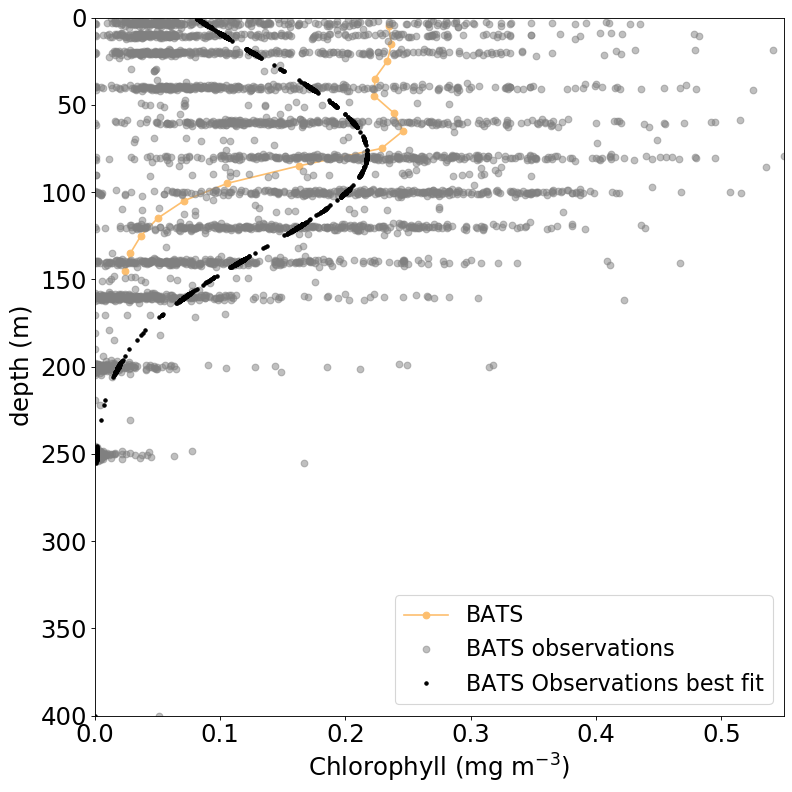

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')

y, x = np.asarray(chl_bats[idyy]), np.asarray(df_bats['Depth'][mask][idyy])
ax.plot(y,x, 'o', color='gray', alpha=0.5, label='BATS observations')

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
  
# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, y)
  
#popt returns the best fit values for parameters of the given model (func)
print (popt)
  
ym = func(x, popt[0], popt[1], popt[2])
ax.plot(ym, x, '.',c='k', label='BATS Observations best fit')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,400])
ax.invert_yaxis()
ax.set_xlim([0,0.55])

fig.tight_layout()

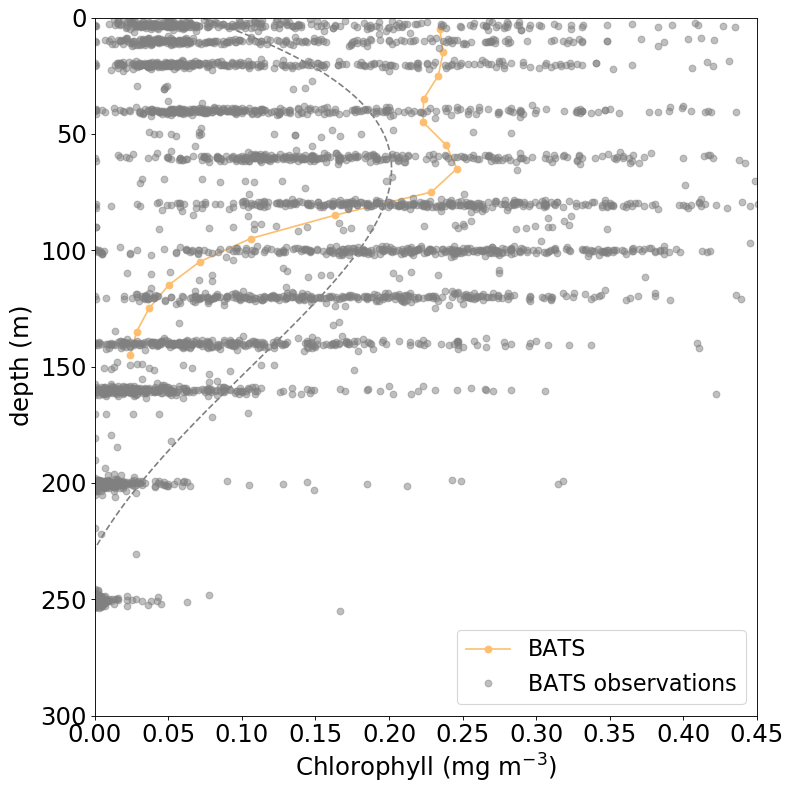

In [ ]:
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)

fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')

y, x = np.asarray(chl_bats[idyy]), np.asarray(df_bats['Depth'][mask][idyy])
ax.plot(y,x, 'o', color='gray', alpha=0.5, label='BATS observations')
# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c,d,e,f = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c,d,e,f)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,300])
ax.invert_yaxis()
ax.set_xlim([0,0.45])

fig.tight_layout()

In [ ]:
max(x)

699.2

### Any depth levels that are less than zero, make them into not a value, and remove them fromt he dataset!

In [ ]:
df_hot['Chla(mg/m3)'][df_hot['Depth(m)']<0] = np.nan
df_hot['Depth(m)'][df_hot['Chla(mg/m3)']<0] = np.nan
idxx = np.isfinite(df_hot['Chla(mg/m3)']) & np.isfinite(df_hot['Depth(m)'])

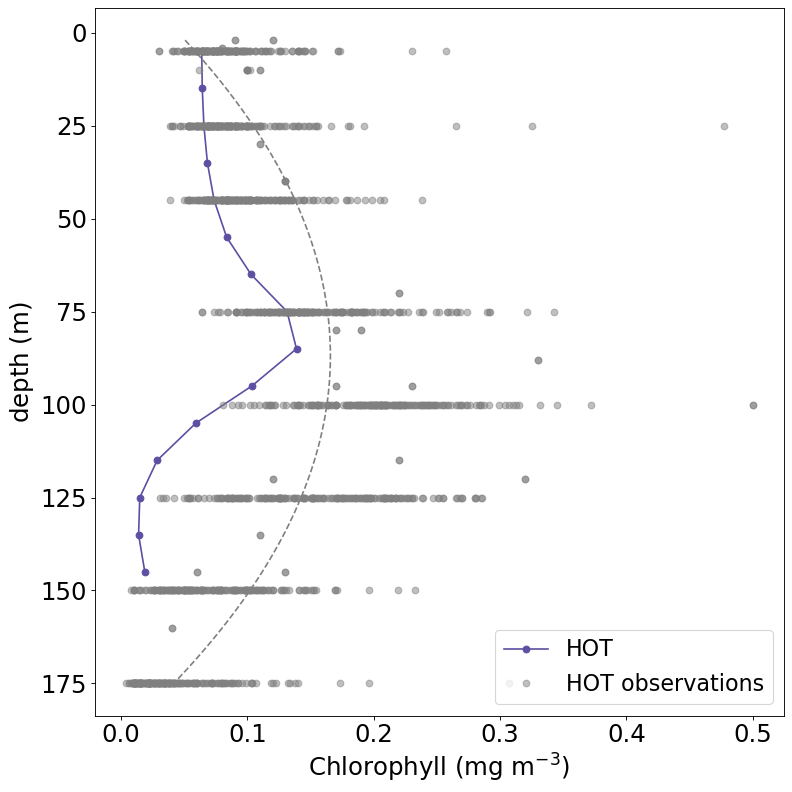

In [ ]:
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)

fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

ax.plot(y,x, 'o', color='gray', alpha=0.5, label='HOT observations')

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
#ax.set_ylim([0,200])
ax.invert_yaxis()
#ax.set_xlim([0,0.35])

fig.tight_layout()

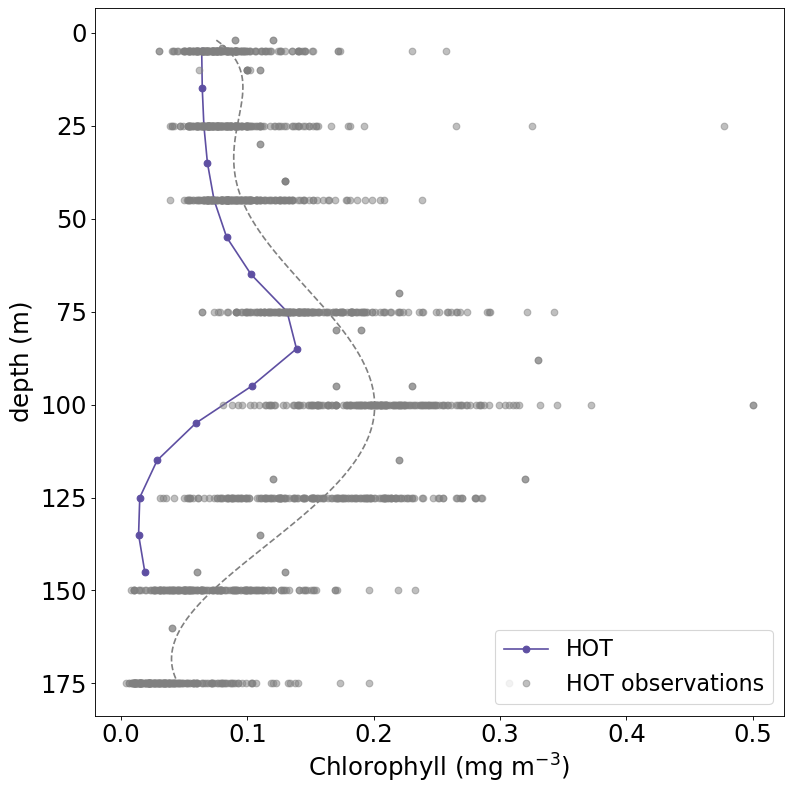

In [ ]:
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)

fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
# define the true objective function
def objective(x, a, b, c, d, e, f,g):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6) + g

ax.plot(y,x, 'o', color='gray', alpha=0.5, label='HOT observations')

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f,g = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f,g)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
#ax.set_ylim([0,200])
ax.invert_yaxis()
#ax.set_xlim([0,0.35])

fig.tight_layout()

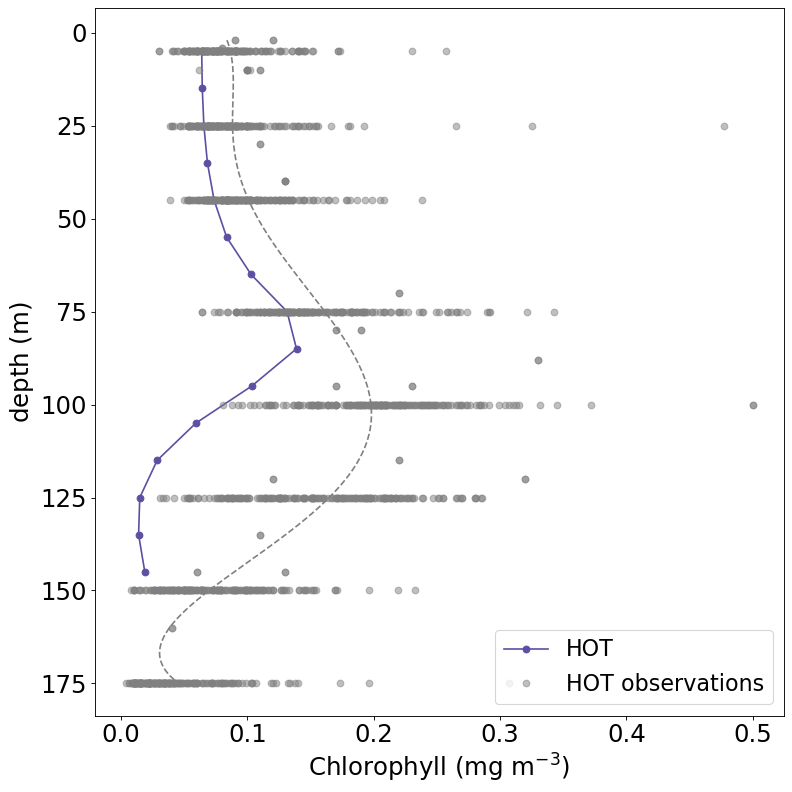

In [ ]:
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)

fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

ax.plot(y,x, 'o', color='gray', alpha=0.5, label='HOT observations')

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
#ax.set_ylim([0,200])
ax.invert_yaxis()
#ax.set_xlim([0,0.35])

fig.tight_layout()

## Gaussian 

[ 0.1813327  89.60288669 53.18186053]


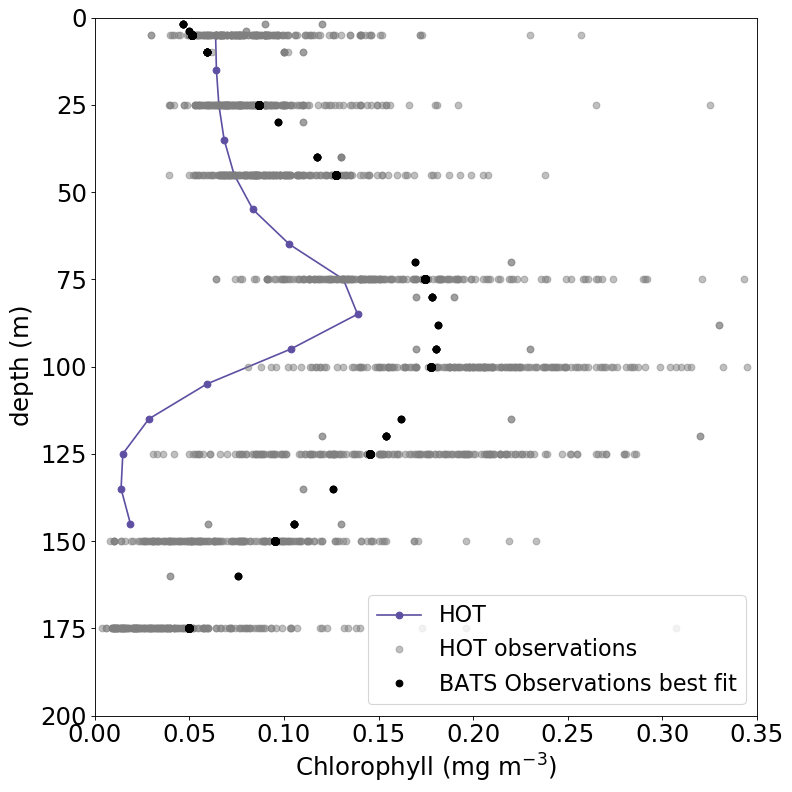

In [ ]:
import matplotlib.transforms as mtransforms
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
ax.plot(y,x, 'o', color='gray', alpha=0.5, label='HOT observations')
# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, y)
  
#popt returns the best fit values for parameters of the given model (func)
print (popt)
  
ym = func(x, popt[0], popt[1], popt[2])
ax.plot(ym, x, 'o',c='k', label='BATS Observations best fit')

ax.legend(loc='lower right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,200])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

## Add both of them into a final figure...

[ 0.1813327  89.60288669 53.18186053]


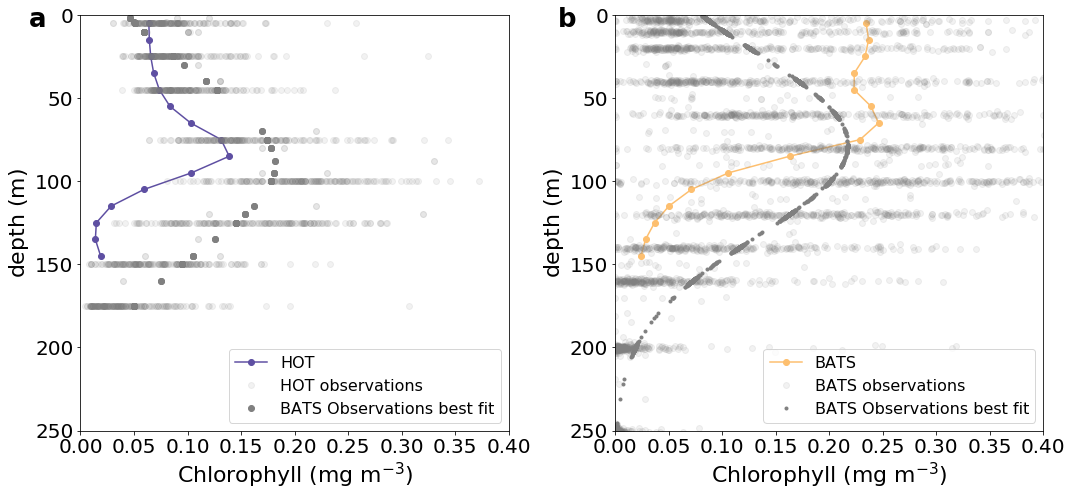

In [ ]:
#fig = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 7))

## HOT 
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')
# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
ax.plot(y,x, 'o', color='gray', alpha=0.1, label='HOT observations')
# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, y)
#popt returns the best fit values for parameters of the given model (func)
print (popt)
ym = func(x, popt[0], popt[1], popt[2])
ax.plot(ym, x, 'o',c='gray', label='BATS Observations best fit')
ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,250])
ax.invert_yaxis()
ax.set_xlim([0,0.4])

## BATS -------
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
y, x = np.asarray(chl_bats[idyy]), np.asarray(df_bats['Depth'][mask][idyy])
ax.plot(y,x, 'o', color='gray', alpha=0.1, label='BATS observations')
# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Executing curve_fit on noisy data
popt, pcov = curve_fit(func, x, y)
#popt returns the best fit values for parameters of the given model (func)
ym = func(x, popt[0], popt[1], popt[2])
ax.plot(ym, x, '.',c='gray', label='BATS Observations best fit')
ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,250])
ax.invert_yaxis()
ax.set_xlim([0,0.4])
fig.text(0.03, 0.94, 'a',fontsize=26, fontweight='bold')
fig.text(0.52, 0.94, 'b',fontsize=26, fontweight='bold')

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/HOT_BATS_vs_obs_gaussian.png',dpi=600, bbox_inches='tight')

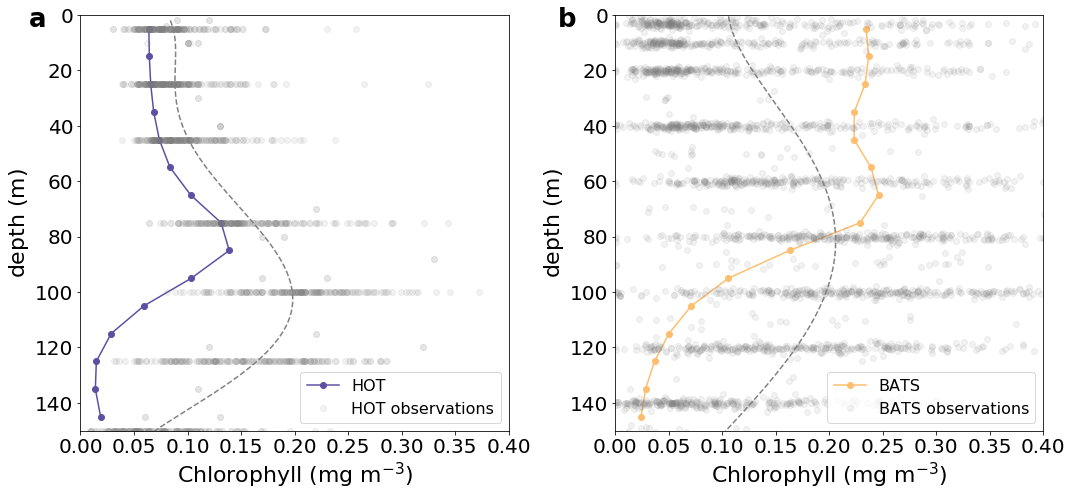

In [ ]:
#fig = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
# define the true objective function
def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

ax.plot(y,x, 'o', color='gray', alpha=0.1, label='HOT observations')

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d, e, f = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d, e, f)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,150])
ax.invert_yaxis()
ax.set_xlim([0,0.4])

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')

y, x = np.asarray(chl_bats[idyy]), np.asarray(df_bats['Depth'][mask][idyy])
ax.plot(y,x, 'o', color='gray', alpha=0.1, label='BATS observations')
# define the true objective function
def objective(x, a, b, c, d, e, f,g):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6) +g

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c,d,e,f,g = popt

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = objective(x_line, a, b, c,d,e,f,g)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')

ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,150])
ax.invert_yaxis()
ax.set_xlim([0,0.4])
fig.text(0.03, 0.94, 'a',fontsize=26, fontweight='bold')
fig.text(0.52, 0.94, 'b',fontsize=26, fontweight='bold')

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/HOT_BATS_vs_obs_best_fit.png',dpi=600, bbox_inches='tight')

## Last Attempt

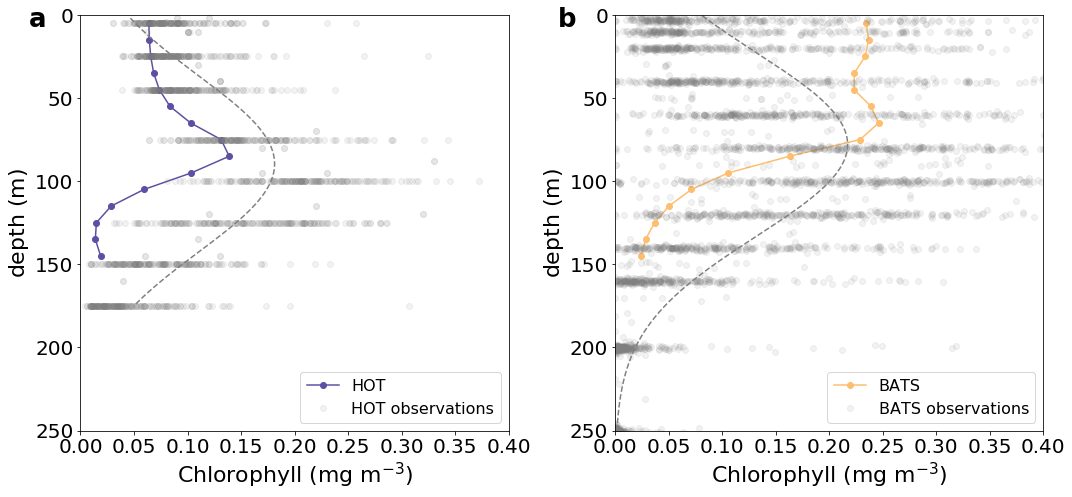

In [ ]:
#fig = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 7))

## HOT 
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')
# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
y, x = df_hot['Chla(mg/m3)'][idxx], df_hot['Depth(m)'][idxx]
ax.plot(y,x, 'o', color='gray', alpha=0.1, label='HOT observations')

# curve fit
popt, _ = curve_fit(func, x, y)
# summarize the parameter values
a, x0, sigma = popt
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = func(x_line, a, x0,sigma)
# create a line plot for the mapping function
pyplot.plot(y_line, x_line, '--', color='gray')
ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,250])
ax.invert_yaxis()
ax.set_xlim([0,0.4])

## BATS -------
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
y, x = np.asarray(chl_bats[idyy]), np.asarray(df_bats['Depth'][mask][idyy])
ax.plot(y,x, 'o', color='gray', alpha=0.1, label='BATS observations')
# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# curve fit
popt, _ = curve_fit(func, x, y)
# summarize the parameter values
a, x0, sigma = popt
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.1)
# calculate the output for the range
y_line = func(x_line, a, x0,sigma)
pyplot.plot(y_line, x_line, '--', color='gray')
ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,250])
ax.invert_yaxis()
ax.set_xlim([0,0.4])
fig.text(0.03, 0.94, 'a',fontsize=26, fontweight='bold')
fig.text(0.52, 0.94, 'b',fontsize=26, fontweight='bold')

fig.tight_layout()

## Finding unique depths, and trying to plot it this way?

In [23]:
depth_hot = np.unique(df_hot['Depth(m)'])

In [24]:
avg_hot_chla = np.zeros(depth_hot[depth_hot>0].size) # Make the average file the size of unique depths 
std_hot_chla = np.zeros(depth_hot[depth_hot>0].size)
avg_hot_chla[:] = np.nan # Make this file NaN
std_hot_chla[:] = np.nan

for idx,i in enumerate(depth_hot[depth_hot>0]): 
    avg_hot_chla[idx] = df_hot['Chla(mg/m3)'][df_hot['Depth(m)']==i].mean()
    std_hot_chla[idx] = df_hot['Chla(mg/m3)'][df_hot['Depth(m)']==i].std()
    if avg_hot_chla[idx] <0:
        avg_hot_chla[idx] = np.nan

In [25]:
np.mean(std_hot_chla)

0.08258066374741921

In [120]:
bats_depth = np.unique(df_bats['Depth']) # Finding the unique depths in the BATS dataset to average through

In [121]:
depth_hot[depth_hot>0] # Removing all of the negative depths. 

array([  2,   4,   5,  10,  25,  30,  40,  45,  70,  75,  80,  88,  95,
       100, 115, 120, 125, 135, 145, 150, 160, 175])

In [122]:
avg_bats_chla = np.zeros(depth_hot[depth_hot>0].size) # Make the average file the size of unique depths 
std_bats_chla = np.zeros(depth_hot[depth_hot>0].size)
avg_bats_chla[:] = np.nan # Make this file NaN
std_bats_chla[:] = np.nan

for jdx, j in enumerate(depth_hot[depth_hot>0]):
        #hot_depth_range = (df_bats['Depth']<i+1) & (df_bats['Depth']>i)
    avg_bats_chla[jdx] = np.nanmean(chl_bats[(df_bats['Depth']<j+1) & (df_bats['Depth']>j)])
    std_bats_chla[jdx] = chl_bats[(df_bats['Depth']<j+1) & (df_bats['Depth']>j)].std()
    #if avg_bats_chla[jdx] <0:
    #    avg_bats_chla[jdx] = np.nan

In [123]:
avg_bats_chla[~np.isnan(avg_bats_chla)]

array([0.09431818, 0.06738462, 0.16411111, 0.12083193, 0.093     ,
       0.12534884, 0.17816667, 0.178     , 0.24176119, 0.15925   ,
       0.303     , 0.23316794, 0.13      , 0.15963359, 0.03633333,
       0.04514563])

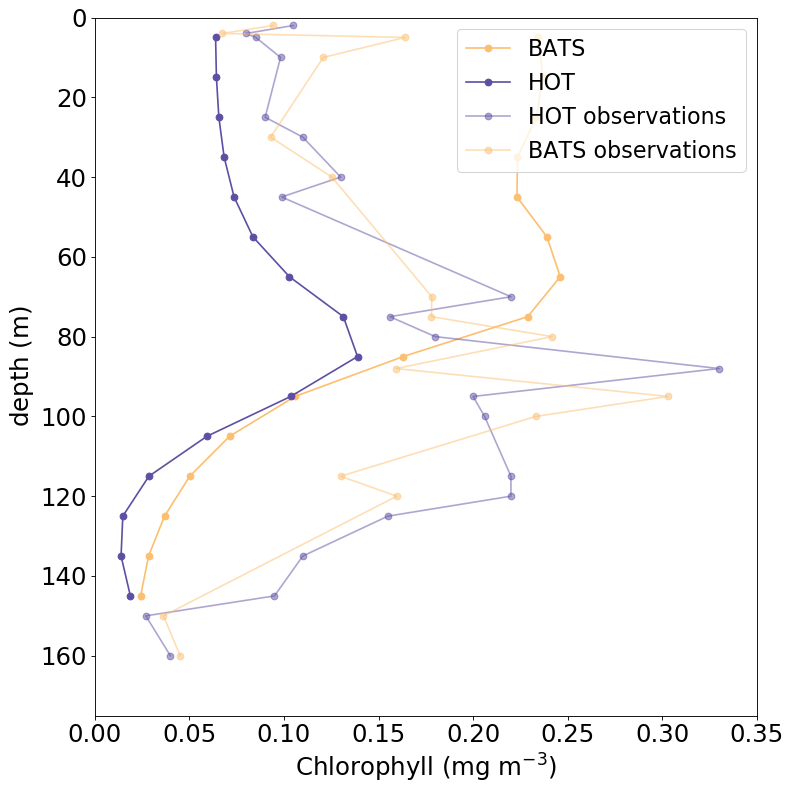

In [124]:
import matplotlib.transforms as mtransforms

import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')
ax.plot(avg_hot_chla,depth_hot[depth_hot>0], '-o', color=cmap(9), alpha=0.5, label='HOT observations')
ax.plot(avg_bats_chla[~np.isnan(avg_bats_chla)],depth_hot[depth_hot>0][~np.isnan(avg_bats_chla)], '-o', color=cmap(3), alpha=0.5, label='BATS observations')

ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

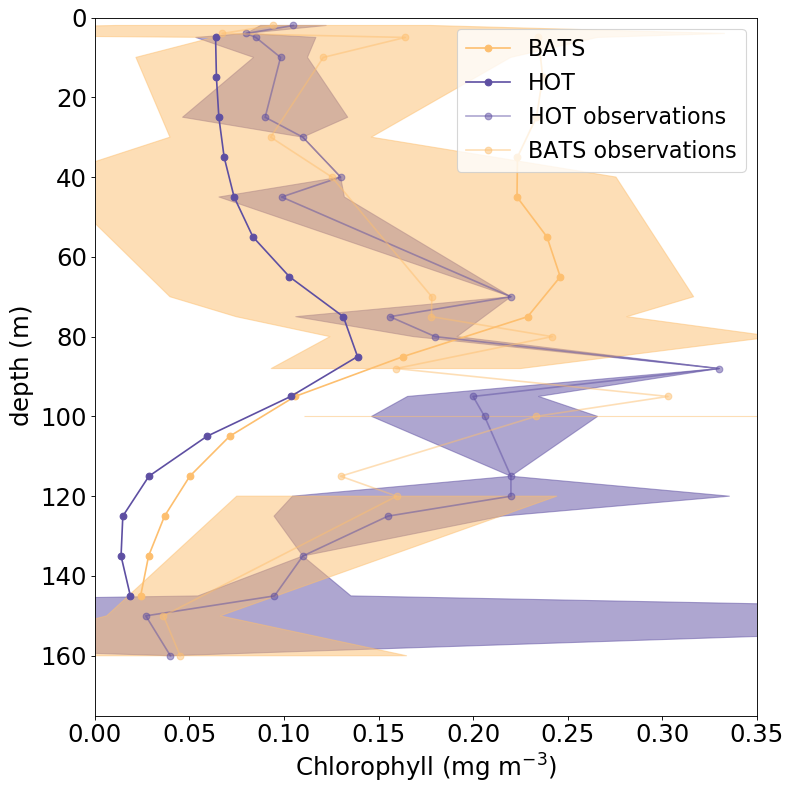

In [125]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

# HOT Observations
x1 = avg_hot_chla
y1 = depth_hot[depth_hot>0]
c1 = std_hot_chla
ax.plot(x1,y1, '-o', color=cmap(9), alpha=0.5, label='HOT observations')
ax.fill_betweenx(y1, (x1-c1), (x1+c1), color=cmap(9), alpha=.5)

# BATS observations 
x2 = avg_bats_chla[~np.isnan(avg_bats_chla)]
y2 = depth_hot[depth_hot>0][~np.isnan(avg_bats_chla)]
c2 = std_bats_chla[~np.isnan(avg_bats_chla)]
ax.plot(x2,y2, '-o', color=cmap(3), alpha=0.5, label='BATS observations')
ax.fill_betweenx(y2, (x2-c2), (x2+c2), color=cmap(3), alpha=.5)

ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

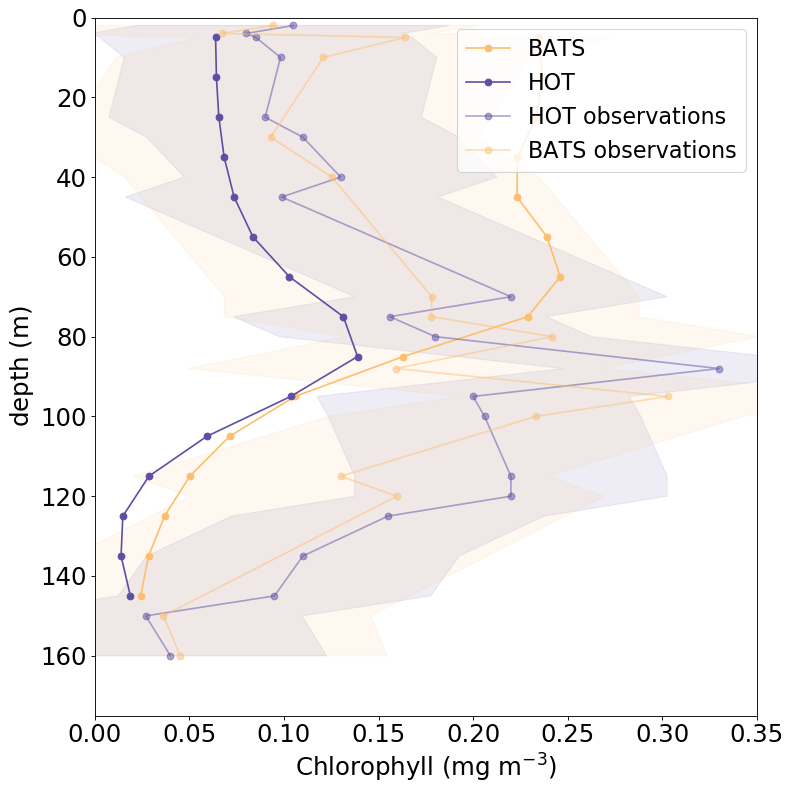

In [126]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(np.nanmean(chla_new[:,:,121,116],axis=0),pp_ds.z_t_150m/100, '-o', color=cmap(3),label='BATS')
ax.plot(np.nanmean(chla_new[:,:,112,22],axis=0),pp_ds.z_t_150m/100, '-o',color=cmap(9),label='HOT')

# HOT Observations
x1 = avg_hot_chla
y1 = depth_hot[depth_hot>0]
c1 = np.nanmean(std_hot_chla)
ax.plot(x1,y1, '-o', color=cmap(9), alpha=0.5, label='HOT observations')
ax.fill_betweenx(y1, (x1-c1), (x1+c1), color=cmap(9), alpha=.1)

# BATS observations 
x2 = avg_bats_chla[~np.isnan(avg_bats_chla)]
y2 = depth_hot[depth_hot>0][~np.isnan(avg_bats_chla)]
c2 = np.nanmean(std_bats_chla[~np.isnan(avg_bats_chla)])
ax.plot(x2,y2, '-o', color=cmap(3), alpha=0.5, label='BATS observations')
ax.fill_betweenx(y2, (x2-c2), (x2+c2), color=cmap(3), alpha=.1)

ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

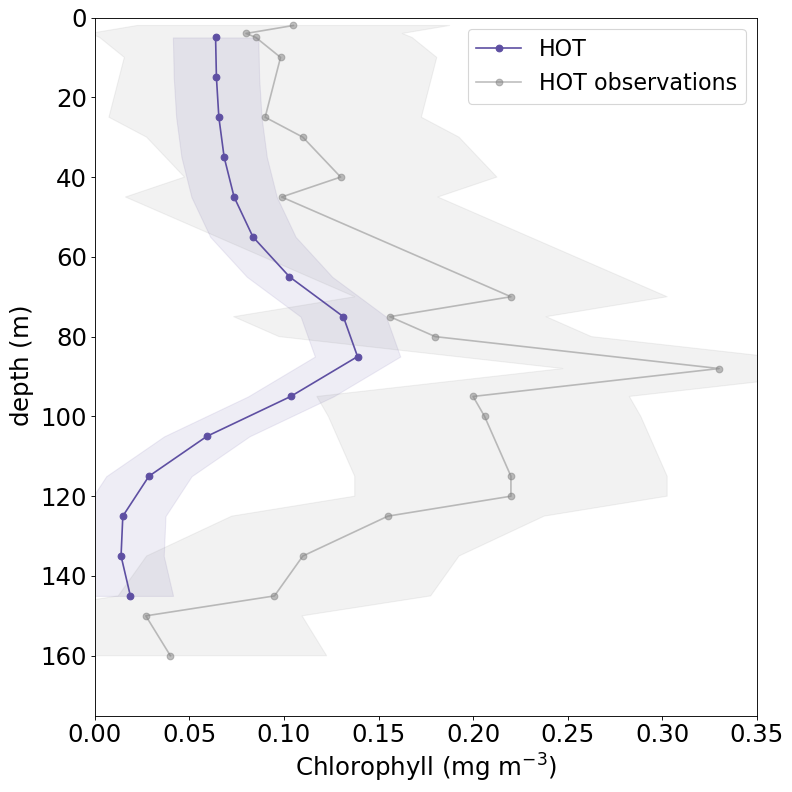

In [133]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
x = np.nanmean(chla_new[:,:,112,22],axis=0)
y = pp_ds.z_t_150m/100
ci = np.mean(np.std(chla_new[:,:,112,22],axis=0))
ax.plot(x,y, '-o',color=cmap(9),label='HOT')
ax.fill_betweenx(y, (x-ci), (x+ci), color=cmap(9), alpha=.1)

# HOT Observations
x1 = avg_hot_chla
y1 = depth_hot[depth_hot>0]
c1 = np.nanmean(std_hot_chla)
ax.plot(x1,y1, '-o', color='gray', alpha=0.5, label='HOT observations')
ax.fill_betweenx(y1, (x1-c1), (x1+c1), color='gray', alpha=.1)

ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

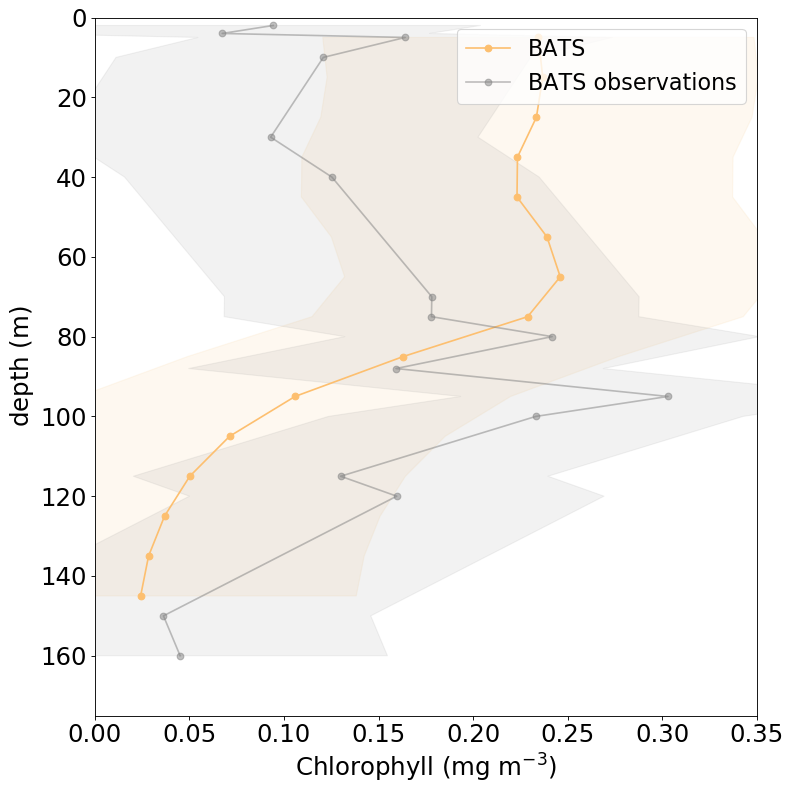

In [143]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
cmap1=matplotlib.cm.get_cmap('Spectral', 100)
#dep = ds.z_t/100
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
x = np.nanmean(chla_new[:,:,121,116],axis=0)
y = pp_ds.z_t_150m/100
ci = np.nanmean(np.std(chla_new[:,:,121,116],axis=0))
ax.plot(x,y, '-o',color=cmap(3),label='BATS')
ax.fill_betweenx(y, (x-ci), (x+ci), color=cmap(3), alpha=.1)

# BATS observations 
x2 = avg_bats_chla[~np.isnan(avg_bats_chla)]
y2 = depth_hot[depth_hot>0][~np.isnan(avg_bats_chla)]
c2 = np.nanmean(std_bats_chla[~np.isnan(avg_bats_chla)])
ax.plot(x2,y2, '-o', color='gray', alpha=0.5, label='BATS observations')
ax.fill_betweenx(y2, (x2-c2), (x2+c2), color='gray', alpha=.1)

ax.legend(loc='upper right', fontsize=20)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.35])

fig.tight_layout()

## One Figure with two subfigures one with HOT and one with BATS

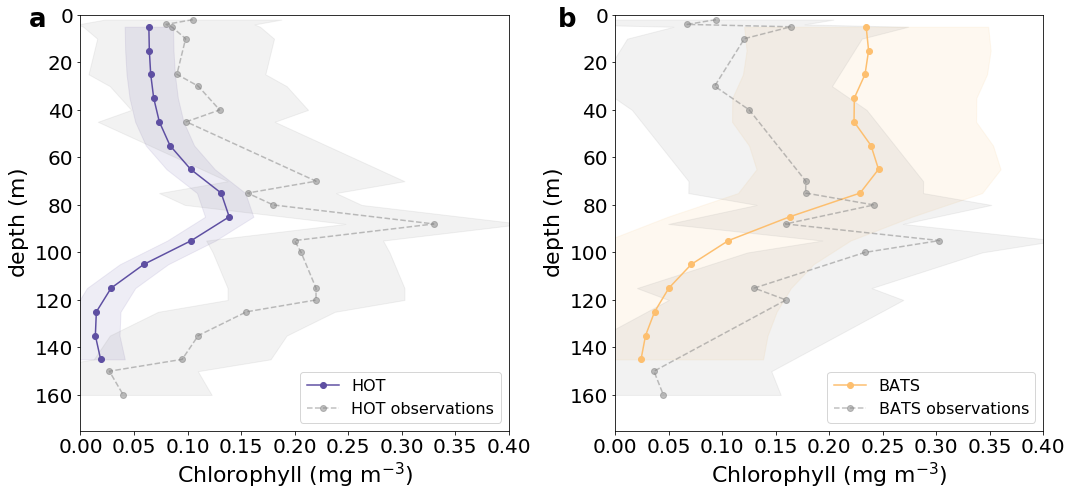

In [164]:
#fig = plt.subplots(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 2, 1)
x = np.nanmean(chla_new[:,:,112,22],axis=0)
y = pp_ds.z_t_150m/100
ci = np.mean(np.std(chla_new[:,:,112,22],axis=0))
ax.plot(x,y, '-o',color=cmap(9),label='HOT')
ax.fill_betweenx(y, (x-ci), (x+ci), color=cmap(9), alpha=.1)

# HOT Observations
x1 = avg_hot_chla
y1 = depth_hot[depth_hot>0]
c1 = np.nanmean(std_hot_chla)
ax.plot(x1,y1, '--o', color='gray', alpha=0.5, label='HOT observations')
ax.fill_betweenx(y1, (x1-c1), (x1+c1), color='gray', alpha=.1)

ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.4])

ax = fig.add_subplot(1, 2, 2)
x = np.nanmean(chla_new[:,:,121,116],axis=0)
y = pp_ds.z_t_150m/100
ci = np.nanmean(np.std(chla_new[:,:,121,116],axis=0))
ax.plot(x,y, '-o',color=cmap(3),label='BATS')
ax.fill_betweenx(y, (x-ci), (x+ci), color=cmap(3), alpha=.1)

# BATS observations 
x2 = avg_bats_chla[~np.isnan(avg_bats_chla)]
y2 = depth_hot[depth_hot>0][~np.isnan(avg_bats_chla)]
c2 = np.nanmean(std_bats_chla[~np.isnan(avg_bats_chla)])
ax.plot(x2,y2, '--o', color='gray', alpha=0.5, label='BATS observations')
ax.fill_betweenx(y2, (x2-c2), (x2+c2), color='gray', alpha=.1)

ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('depth ($m$)', fontsize=22)
ax.set_xlabel('Chlorophyll (mg m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 20);plt.xticks(fontsize= 20);
ax.set_ylim([0,175])
ax.invert_yaxis()
ax.set_xlim([0,0.4])
fig.text(0.03, 0.94, 'a',fontsize=26, fontweight='bold')
fig.text(0.52, 0.94, 'b',fontsize=26, fontweight='bold')

fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/HOT_BATS_vs_obs.png',dpi=600, bbox_inches='tight')